In [1]:
import os

os.chdir("/workspaces/example_digital-twin_incubator_twright/software/incubator")

In [2]:
import sys

sys.path.append("/workspaces/example_digital-twin_incubator_twright/software")

In [3]:
import matplotlib.pyplot as plt

In [4]:
from digital_twin.simulator.verified_plant_simulator import VerifiedPlantMonitor4Params

In [5]:
from verified_twin.lbuc import *
import sage.all as sg
from sage.all import RIF

In [6]:
sg.var("T_A", "T_H")

(T_A, T_H)

In [7]:
plt.rcParams['figure.figsize'] = [60/2.54, 30/2.54]

In [8]:
from incubator.tests.self_adaptation_tests.test_self_adaptation import *

/home/sage/sage/local/lib/python3.9/site-packages/control/xferfcn.py:1498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(data[i][j][k], (int, np.int)):


In [9]:
import numpy as np
from oomodelling import Model

from incubator.calibration.calibrator import Calibrator
from incubator.self_adaptation.controller_optimizer import IControllerOptimizer
from incubator.interfaces.updateable_kalman_filter import IUpdateableKalmanFilter

In [10]:
from digital_twin.calibration.uncertainty_calibrator import UncertaintyCalibrator

In [11]:
properties = [
    Atomic(T_A < RIF(35)),
    G(RIF(0, 1000), Atomic(T_A > RIF(32))),
    G(RIF(0, 1000), ~Atomic(T_A < RIF(34))
                  | G(RIF(0, 50), Atomic(T_A > RIF(32)))
                  & F(RIF(0,50), Atomic(T_A > RIF(34)))),
    Atomic(T_A < RIF(85)),
    G(RIF(0, 1000), Atomic(T_A < RIF(85))),
    Atomic(T_H < RIF(130)),
]

## Self-Adaptation Loop Integration

In [12]:
config = load_config("startup.conf")

n_samples_period = config["physical_twin"]["controller_open_loop"]["n_samples_period"]
n_samples_heating = 5
C_air = config["digital_twin"]["models"]["plant"]["param4"]["C_air"]
G_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
G_box_kf = G_box
C_heater = config["digital_twin"]["models"]["plant"]["param4"]["C_heater"]
G_heater = config["digital_twin"]["models"]["plant"]["param4"]["G_heater"]
initial_box_temperature = 41
initial_heat_temperature = 47
initial_room_temperature = 21  # TODO: Add this parameter to config file.
std_dev = 0.001
step_size = 3.0
anomaly_threshold = 2.0
# Time spent before declaring that there is an self_adaptation_manager, after the first time the self_adaptation_manager occurred.
ensure_anomaly_timer = 1
# Time spent, after the self_adaptation_manager was declared as detected, just so enough data about the system is gathered.
# The data used for recalibration will be in interval [time_first_occurrence, time_data_gathered]
gather_data_timer = 10
cool_down_timer = 5
optimize_controller = True

conv_xatol = 0.1
conv_fatol = 0.1
max_iterations = 200
desired_temperature = 41
max_t_heater = 60
restrict_T_heater = True

# Supervisor parameters
trigger_optimization_threshold = 10.0
heater_underused_threshold = 10.0
wait_til_supervising_timer = 100  # N steps supervisor should wait before kicking in.

tf = 6000

kalman = KalmanFilter4P(step_size, std_dev,
                        C_air, G_box_kf, C_heater, G_heater,
                        initial_room_temperature, initial_heat_temperature, initial_box_temperature)

database = MockDatabase(step_size)
plant_simulator = PlantSimulator4Params()
calibrator = Calibrator(database, plant_simulator, conv_xatol, conv_fatol, max_iterations)
pt_simulator = SystemModel4ParametersOpenLoopSimulator()
ctrl = MockController()

verified_monitor = VerifiedPlantMonitor4Params(properties)
uncertainty_calibrator = UncertaintyCalibrator(database)

if optimize_controller:
    ctrl_optimizer = ControllerOptimizer(database, pt_simulator, ctrl, conv_xatol, conv_fatol, max_iterations, restrict_T_heater, desired_temperature, max_t_heater)
else:
    ctrl_optimizer = NoOPControllerOptimizer()

anomaly_detector = SelfAdaptationManager(anomaly_threshold, ensure_anomaly_timer, gather_data_timer, cool_down_timer,
                                         calibrator, kalman, ctrl_optimizer,
                                         verified_monitor,
                                         uncertainty_calibrator,
                                         lookahead_time=500.0)
# supervisor = SupervisorPeriodicSM(ctrl_optimizer, wait_til_supervising_timer)
supervisor = SupervisorThresholdSM(ctrl_optimizer, desired_temperature, max_t_heater,
                                   trigger_optimization_threshold, heater_underused_threshold,
                                   wait_til_supervising_timer)

m = SelfAdaptationScenario(n_samples_period, n_samples_heating,
                           C_air, G_box, C_heater, G_heater,
                           initial_box_temperature,
                           initial_heat_temperature,
                           initial_room_temperature,
                           kalman, anomaly_detector, supervisor,
                           std_dev)

# Inform mock db of plant _plant.
database.set_models(m.physical_twin.plant, m.physical_twin.ctrl)
# Inform mock of controller
ctrl.set_model(m.physical_twin.ctrl)

# Wire in a custom function for the G_box input, so we can change it.
m.physical_twin.plant.G_box = lambda: G_box if m.time() < 1000 else (G_box * 10 if m.time() < 2000 else G_box)

# Wire in a custom function for the C_air parameter,
# so we mimick a different object being placed in the incubator.
# Commented out because it does not seem to work very well.
# m.physical_twin.plant.C_air = lambda: C_air if m.time() < 1000 else (C_air * 7 if m.time() < 2000 else C_air)

ModelSolver().simulate(m, 0.0, tf, 3.0)

/home/sage/sage/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


running verified monitoring for anomaly between times 1002.5938409201124 and 1035.5938409201124
regenerating model with x=['[1002.5938409201123 .. 1002.5938409201124]', '[116.89228178690598 .. 120.89228178690599]', '[79.238146323910370 .. 83.238146323910371]', '[141.21945977643318 .. 142.21945977643319]', '[7.3338353184845495 .. 8.3338353184845496]']
regenerating model with x=['[1014.5938409194874 .. 1014.5938409208499]', '[118.23301350405208 .. 122.31121655519595]', '[55.774005218580015 .. 60.878789236991203]', '[141.21945977643318 .. 142.21945977643319]', '[7.3338353184845495 .. 8.3338353184845496]']
regenerating model with x=['[1029.5938409179368 .. 1029.5938409218682]', '[109.97937005818705 .. 114.15261884586973]', '[44.025841112264238 .. 48.547981701872403]', '[141.21945977643318 .. 142.21945977643319]', '[7.3338353184845495 .. 8.3338353184845496]']
computing inner dist of 118.89228178690598 and [116.89228142378948 .. 120.89228215092944]
computing inner dist of 119.48352600440944 

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 12026
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
       5.99459384e+03, 5.99759384e+03, 6.00000000e+03])
 t_events: None
        y: array([[0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       ...,
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.994

In [13]:
G(RIF(5,10), Atomic(T_H)).duration

10.0000000000000

In [14]:
m.self_adaptation_manager.state_machine.anomaly_durations

[(1002.5938409201124, 1035.5938409201124),
 (1068.5938409201124, 1101.5938409201124),
 (2010.5938409201124, 2043.5938409201124)]

In [15]:
m.self_adaptation_manager.state_machine.anomaly_parameters

[(1002.5938409201124,
  1502.5938409201124,
  81.23814632391037,
  118.89228178690598,
  21,
  3.0,
  10,
  5,
  142.?,
  8.?,
  227.76228512,
  1.92343277),
 (1068.5938409201124,
  1568.5938409201124,
  38.48557931545541,
  103.27713248422768,
  21,
  3.0,
  10,
  5,
  272.?,
  8.?,
  227.76228512,
  1.92343277),
 (2010.5938409201124,
  2510.5938409201126,
  32.607154528547476,
  59.77326802388883,
  21,
  3.0,
  10,
  0,
  102.?,
  1.?,
  227.76228512,
  1.92343277)]

In [16]:
m.self_adaptation_manager.state_machine.verified_monitoring_results

[[Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 1089.3400176399130], False), ([1134.7238409201133 .. 1134.7321690694485], True), ([1134.7338409201133 .. 2552.5938409201126], True)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 2552.5938409201126], False)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 2552.5938409201126], False)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 2552.5938409201126], True)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 1552.5938409201126], True)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 2552.5938409201126], True)], mask=None)],
 [Signal([1068.5938409201123 .. 2618.5938409201126], [([1068.5938409201123 .. 1101.9423682356885], False), ([1130.6038409201125 .. 2618.5938409201126], True)], mask=None),
  Sign

### Manually do some verified simulation for anomolies

#### Anomaly 1

In [17]:
m.self_adaptation_manager.state_machine.anomaly_parameters[0]

(1002.5938409201124,
 1502.5938409201124,
 81.23814632391037,
 118.89228178690598,
 21,
 3.0,
 10,
 5,
 142.?,
 8.?,
 227.76228512,
 1.92343277)

In [18]:
verified_trace1, verified_model1 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[0])
verified_sigs1 = m.self_adaptation_manager.state_machine.verified_monitoring_results[0]

regenerating model with x=['[1002.5938409201123 .. 1002.5938409201124]', '[118.89228178690598 .. 118.89228178690599]', '[81.238146323910370 .. 81.238146323910371]', '[141.06214013531987 .. 142.37677941754649]', '[7.3114094761993966 .. 8.3562611607697033]']
regenerating model with x=['[1017.5938409193312 .. 1017.5938409210339]', '[112.39988093920439 .. 112.65461473433615]', '[52.828613556739519 .. 56.024629046888010]', '[141.06214013531953 .. 142.37677941754683]', '[7.3114094761990626 .. 8.3562611607700373]']
regenerating model with x=['[1032.5938409185005 .. 1032.5938409221022]', '[104.57937024735646 .. 105.19770126791406]', '[42.343527696888891 .. 45.568745722064364]', '[141.06214013531919 .. 142.37677941754717]', '[7.3114094761987287 .. 8.3562611607703712]']
regenerating model with x=['[1047.5938409176335 .. 1047.5938409232797]', '[104.65314766190930 .. 105.55551709417455]', '[38.449904408950914 .. 41.237563683325015]', '[141.06214013531885 .. 142.37677941754752]', '[7.31140947619839

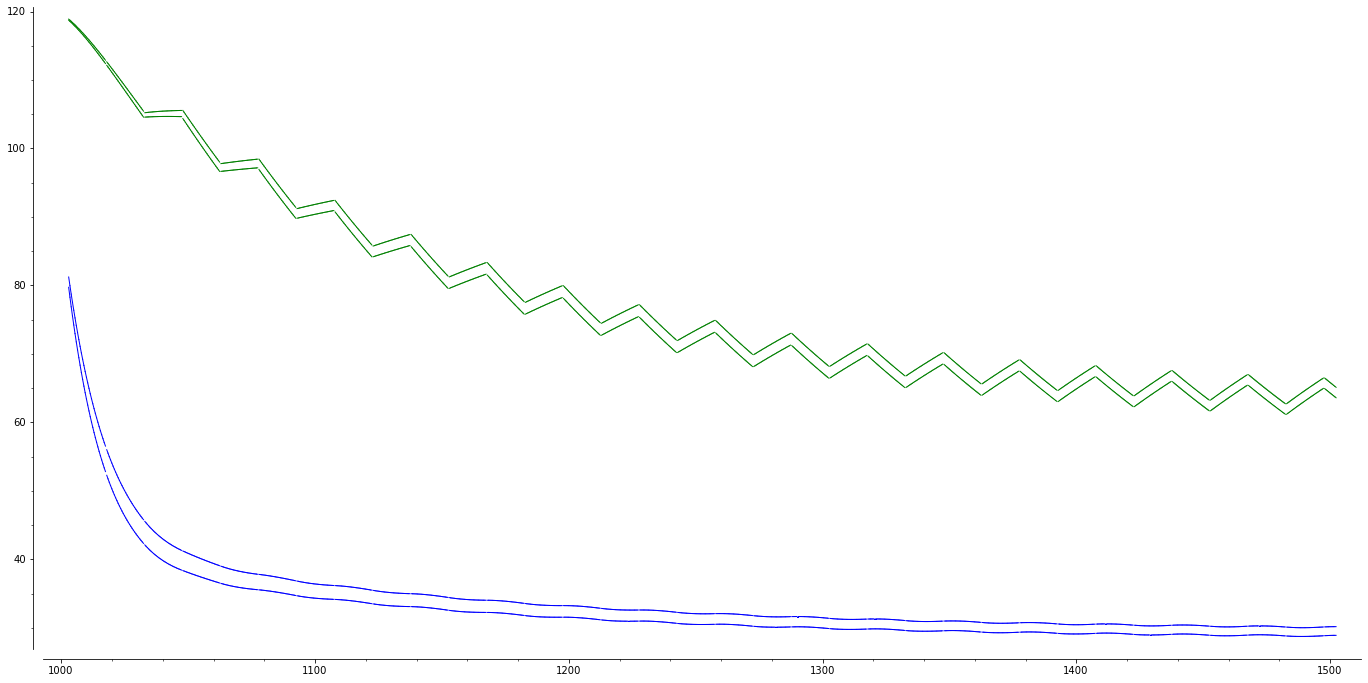

In [19]:
p = verified_trace1.plot(('T_A', 'T_H'), color=('blue', 'green')); p.matplotlib()

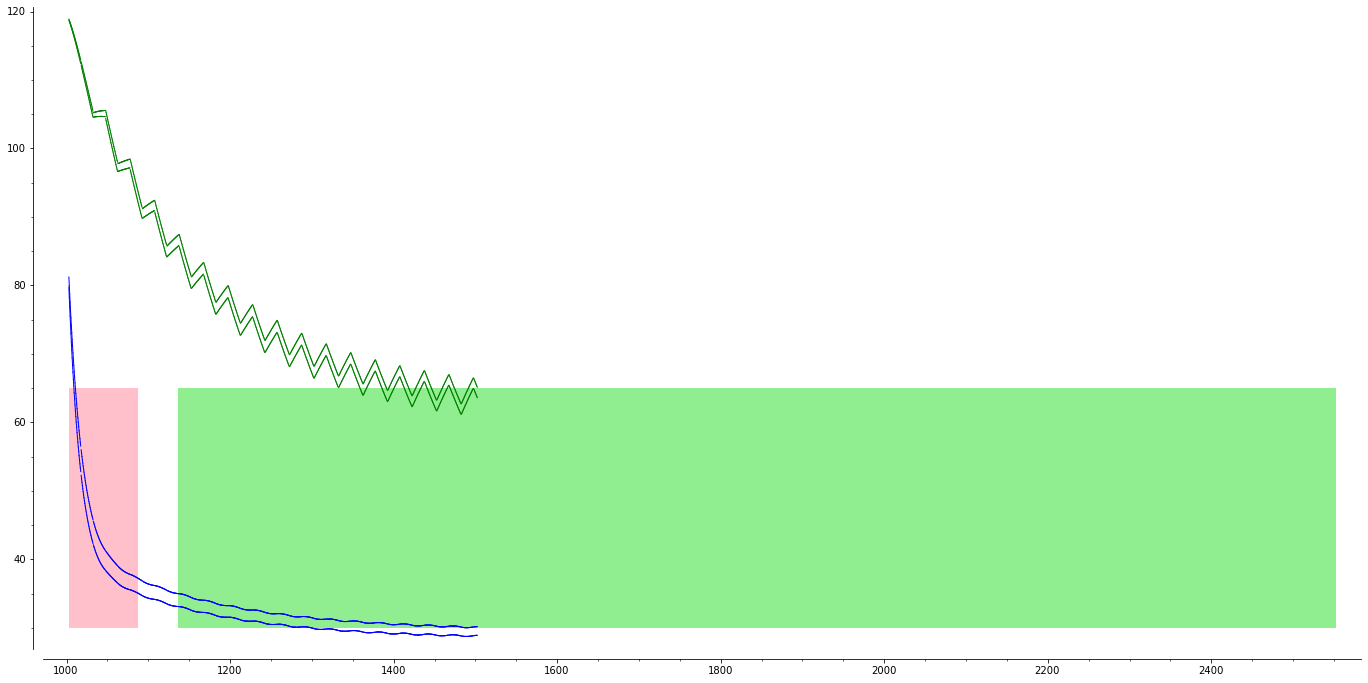

In [20]:
p1 = (verified_sigs1[0].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

/home/sage/sage/local/lib/python3.9/site-packages/sage/plot/contour_plot.py:206: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


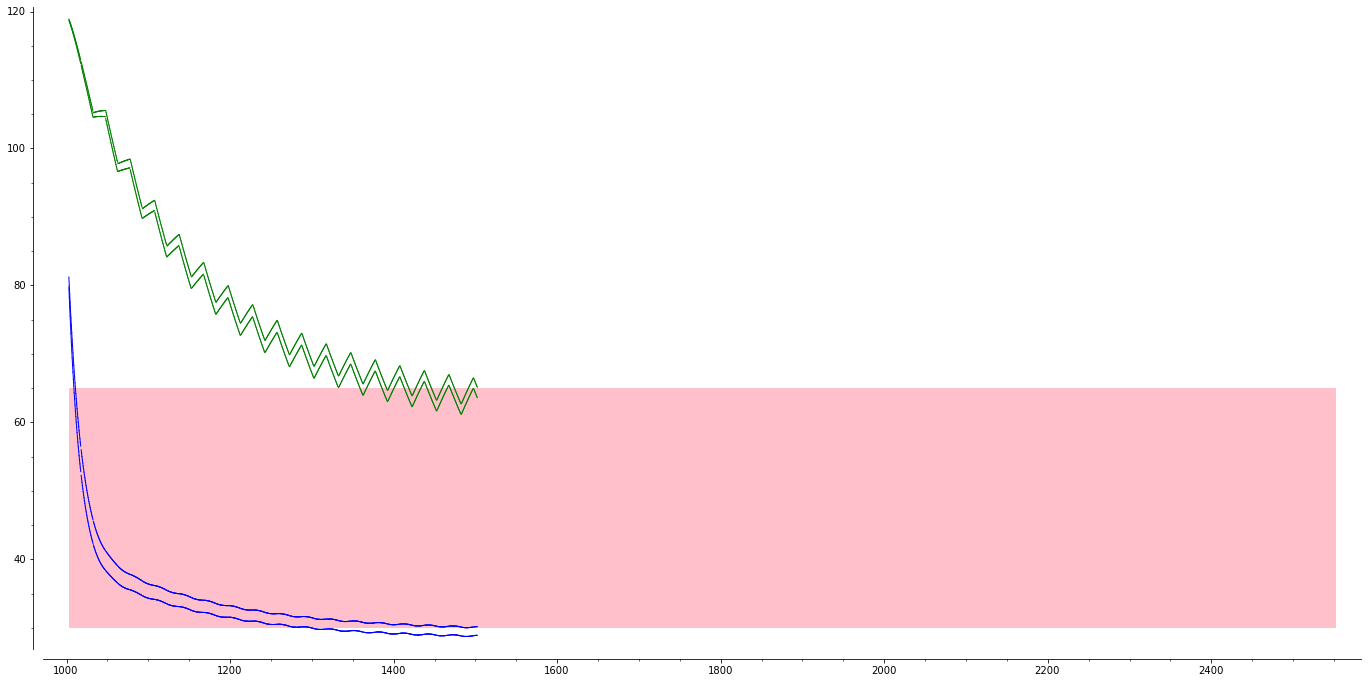

In [21]:
p1 = (verified_sigs1[1].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

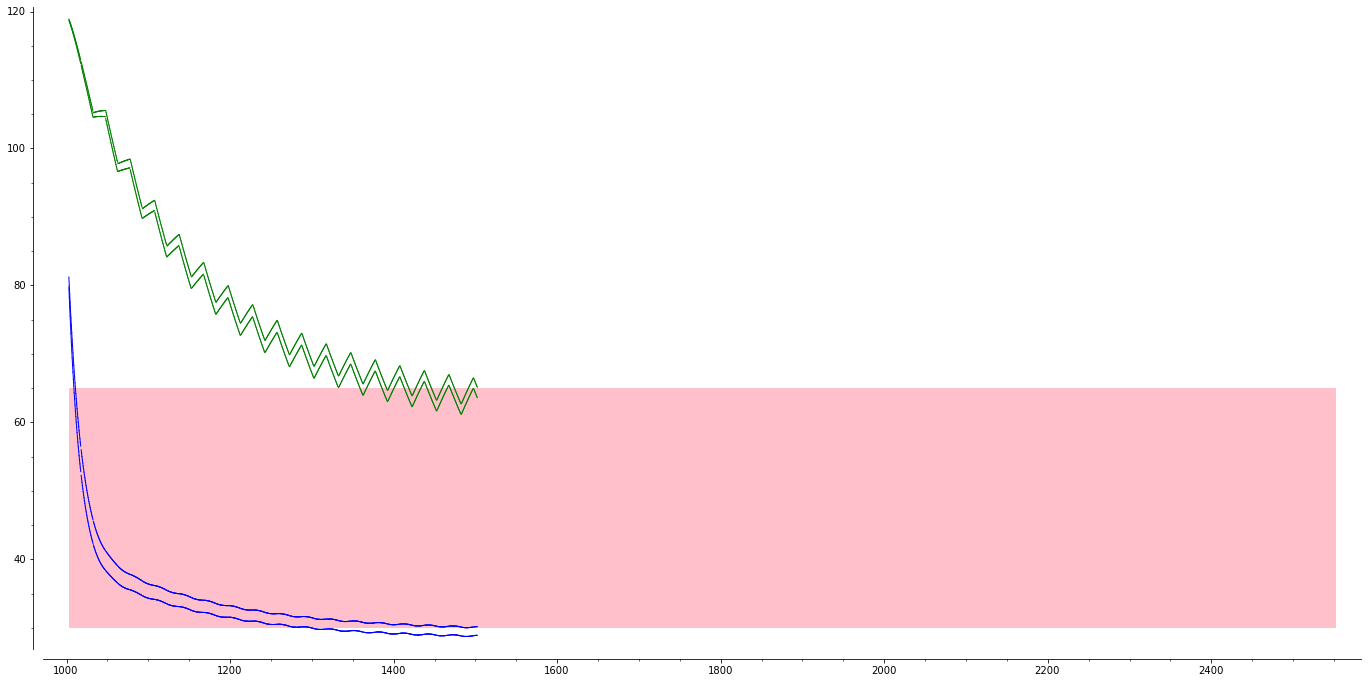

In [22]:
p1 = (verified_sigs1[2].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

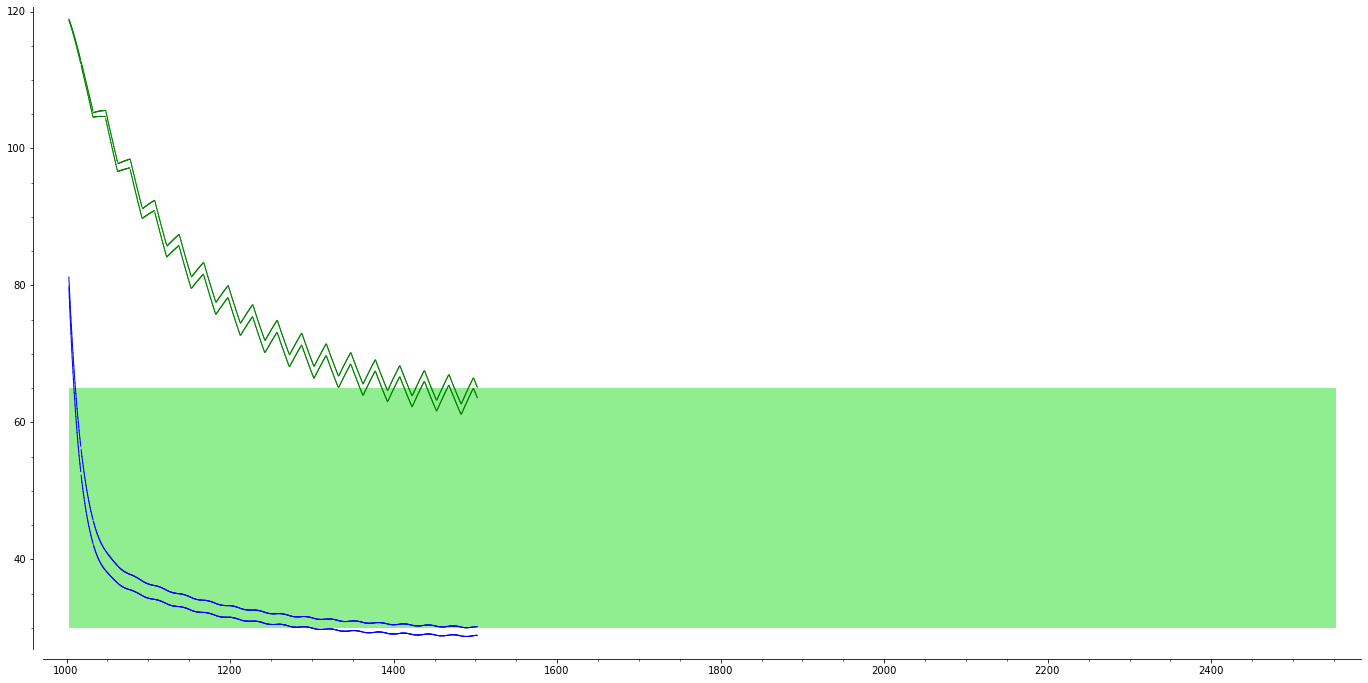

In [23]:
p1 = (verified_sigs1[3].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

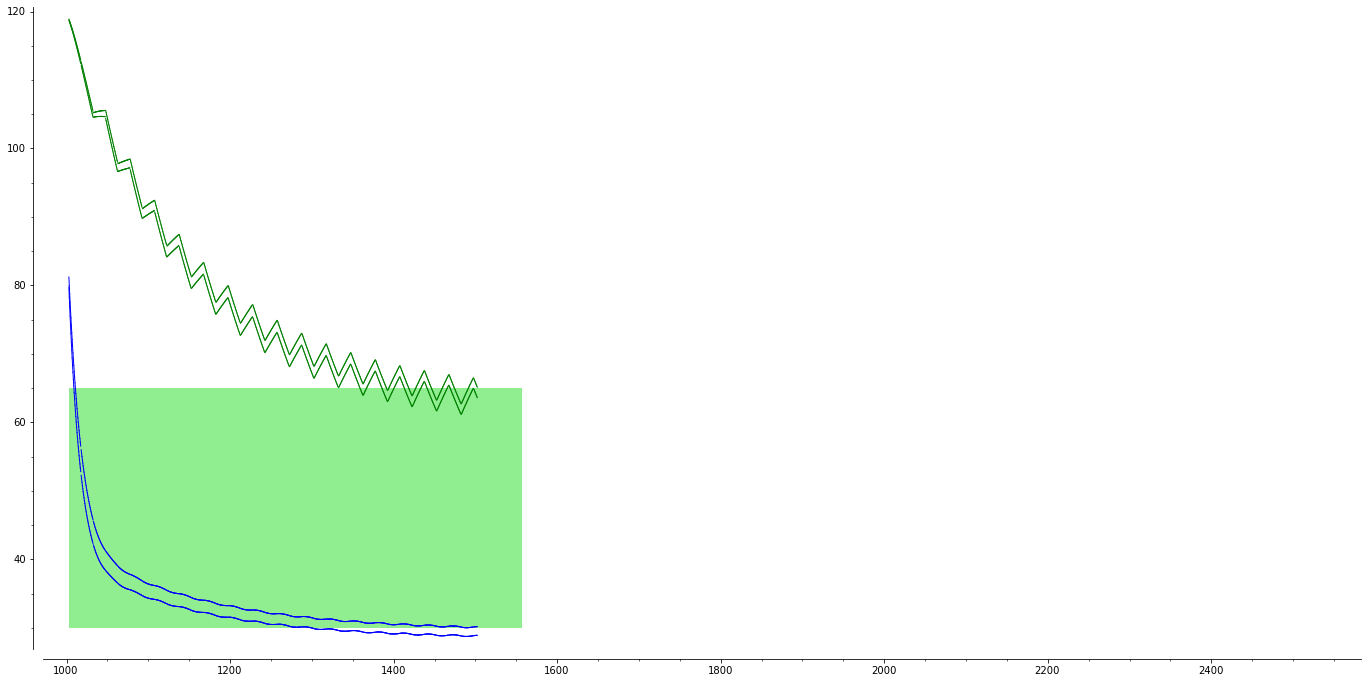

In [24]:
p1 = (verified_sigs1[4].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

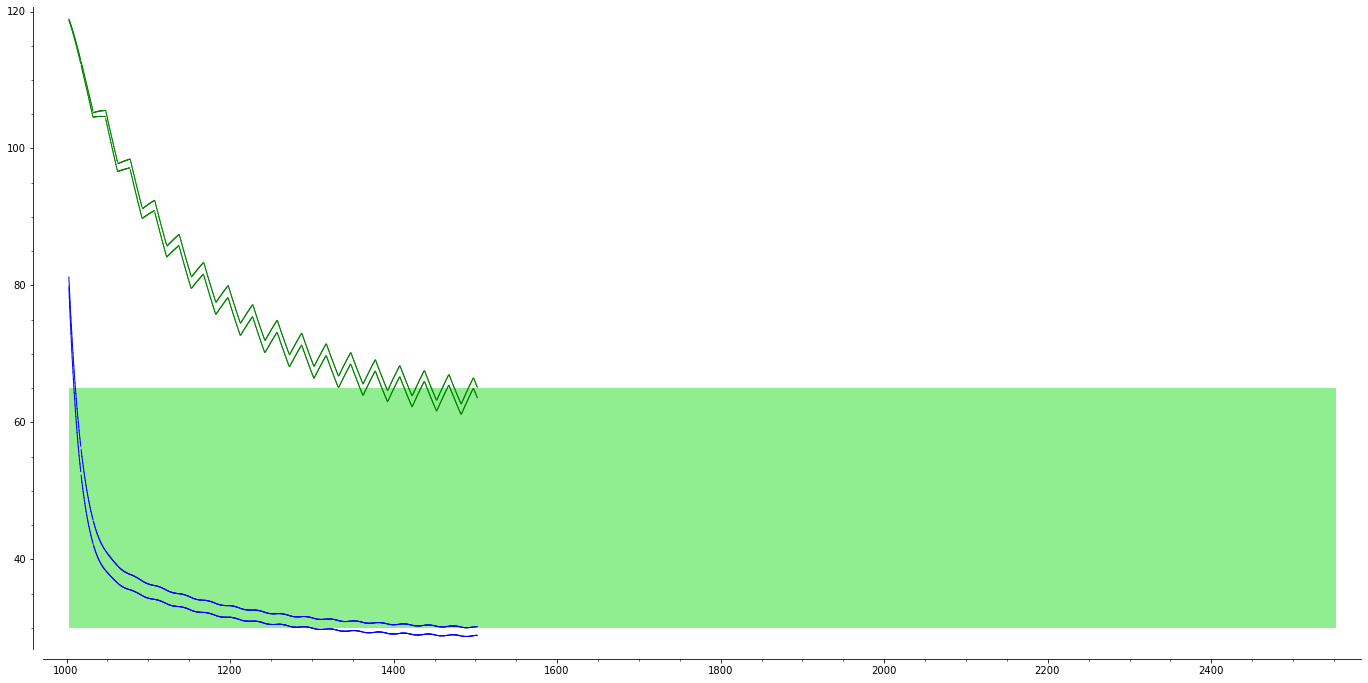

In [25]:
p1 = (verified_sigs1[5].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

### Anomoly 2

In [26]:
m.self_adaptation_manager.state_machine.anomaly_parameters[1]

(1068.5938409201124,
 1568.5938409201124,
 38.48557931545541,
 103.27713248422768,
 21,
 3.0,
 10,
 5,
 272.?,
 8.?,
 227.76228512,
 1.92343277)

In [27]:
verified_trace2, verified_model2 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[1])
verified_sigs2 = m.self_adaptation_manager.state_machine.verified_monitoring_results[1]

regenerating model with x=['[1068.5938409201123 .. 1068.5938409201124]', '[103.27713248422767 .. 103.27713248422768]', '[38.485579315455410 .. 38.485579315455411]', '[271.46343663512794 .. 272.57320836364358]', '[7.7091226589066446 .. 8.9221658717972652]']
regenerating model with x=['[1083.5938409192453 .. 1083.5938409212900]', '[95.465616976656164 .. 95.524636643914534]', '[36.818457526033931 .. 37.700577744642729]', '[271.46343663512760 .. 272.57320836364392]', '[7.7091226589063106 .. 8.9221658717975992]']
regenerating model with x=['[1098.5938409183784 .. 1098.5938409224676]', '[88.393773586217250 .. 88.582048510590923]', '[35.294651165842658 .. 36.638892214004777]', '[271.46343663512726 .. 272.57320836364426]', '[7.7091226589059766 .. 8.9221658717979331]']
regenerating model with x=['[1113.5938409175114 .. 1113.5938409236451]', '[89.762764507731716 .. 90.103916948951366]', '[34.261561166248725 .. 35.829013838667251]', '[271.46343663512692 .. 272.57320836364460]', '[7.70912265890564

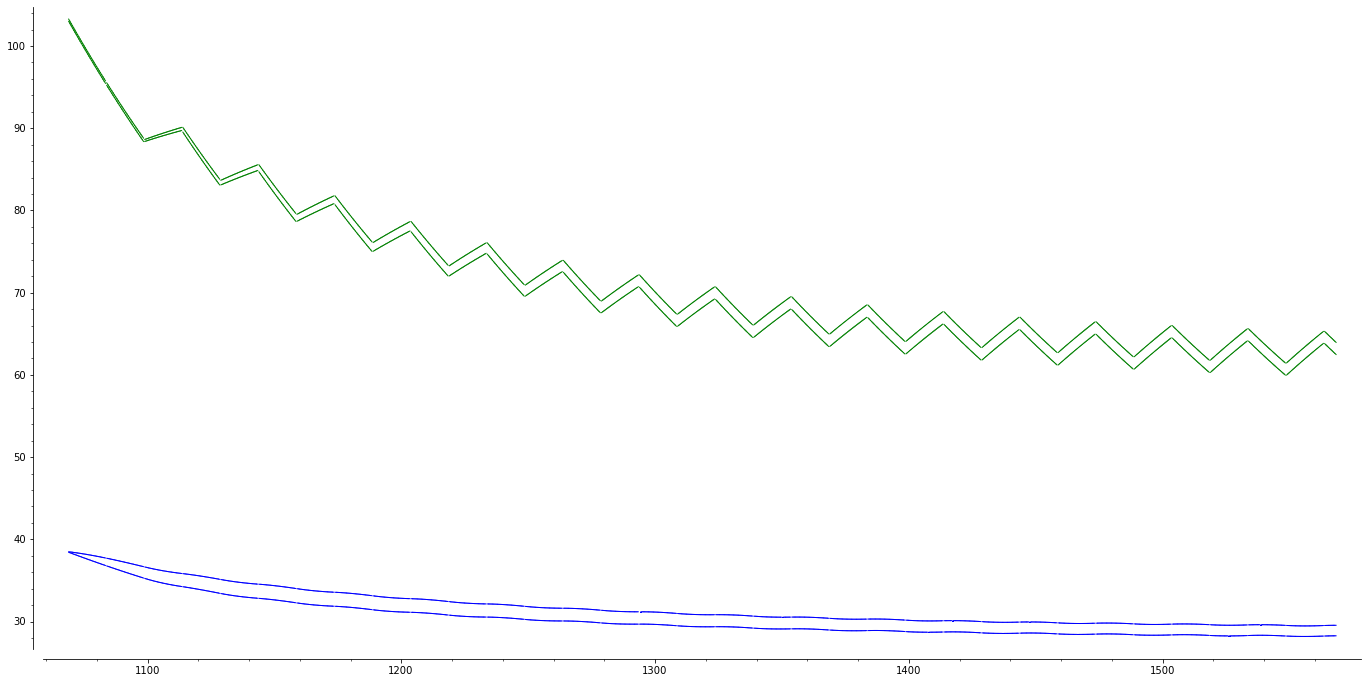

In [28]:
p = verified_trace2.plot(('T_A', 'T_H'), color=('blue', 'green')); p.matplotlib()

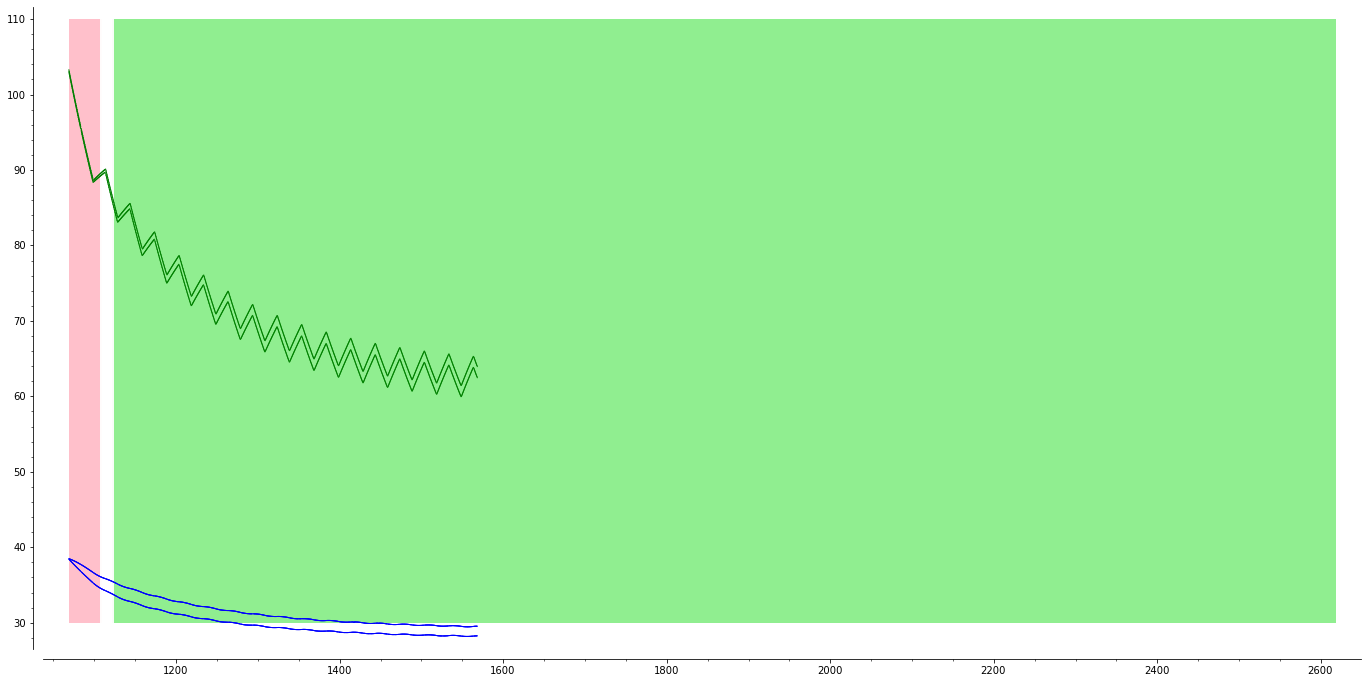

In [29]:
p1 = (verified_sigs2[0].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

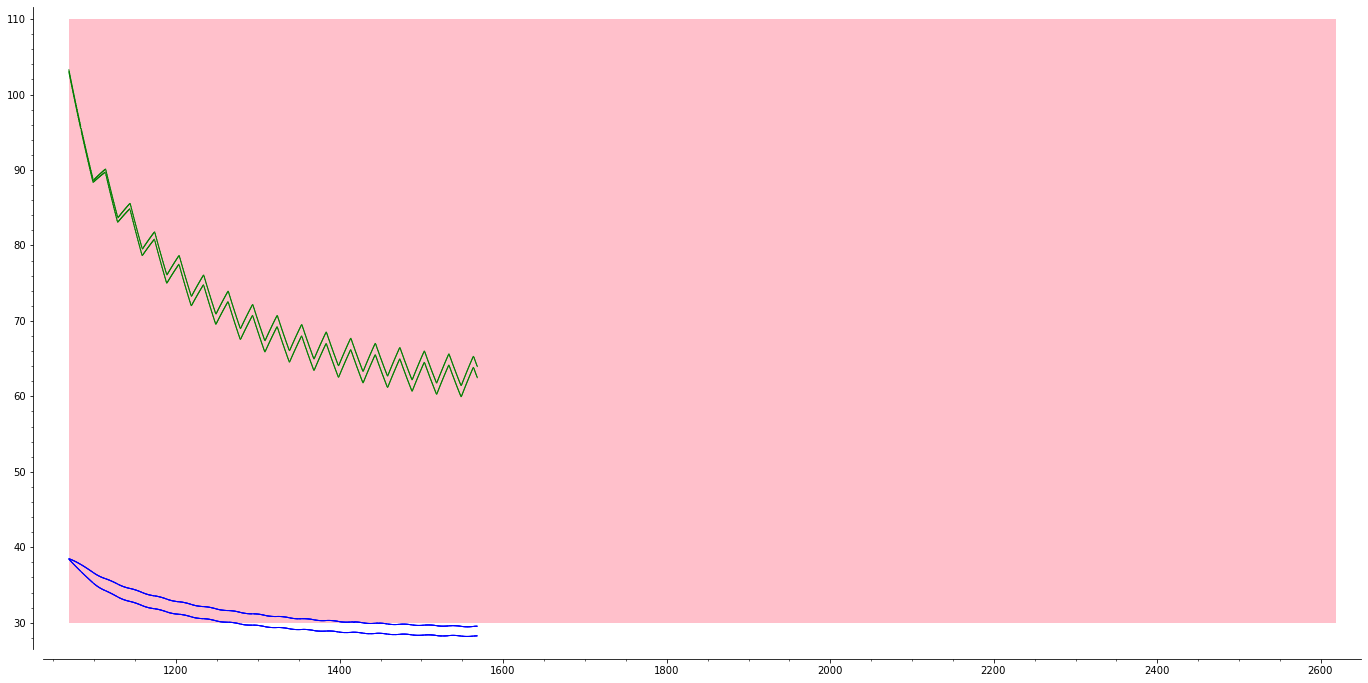

In [30]:
p1 = (verified_sigs2[1].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

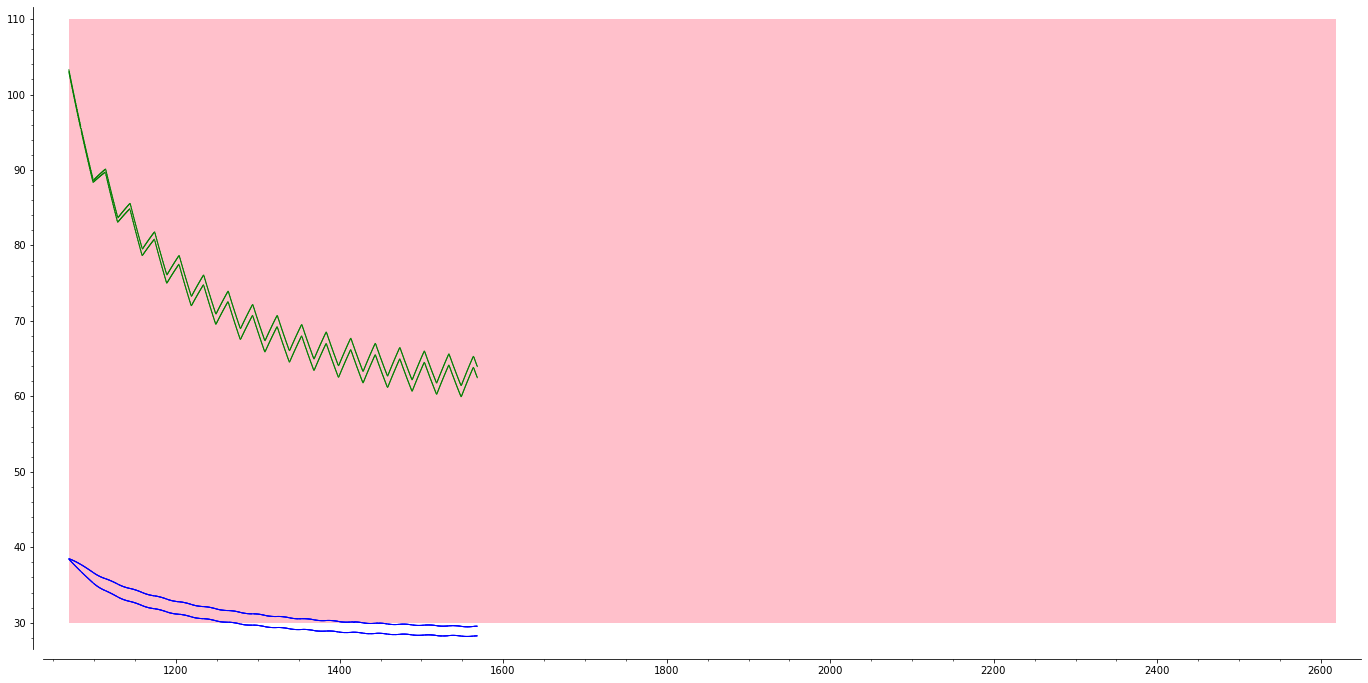

In [31]:
p1 = (verified_sigs2[2].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

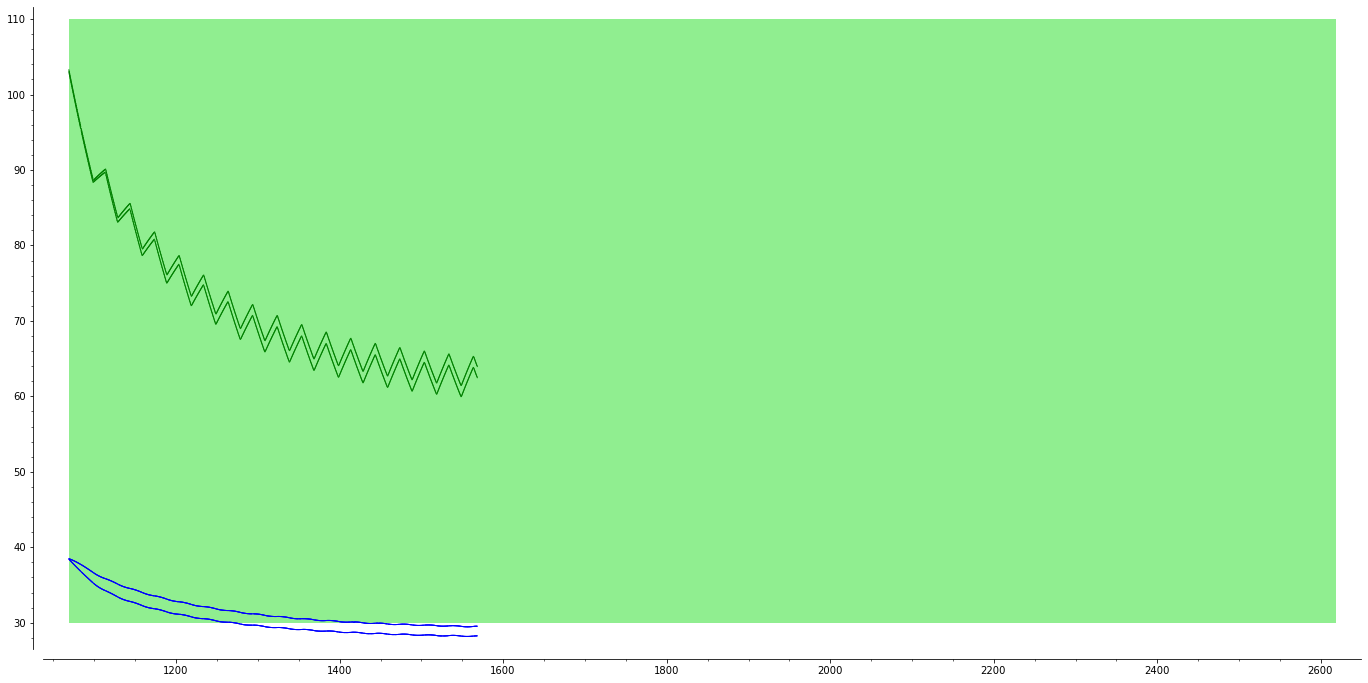

In [32]:
p1 = (verified_sigs2[3].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

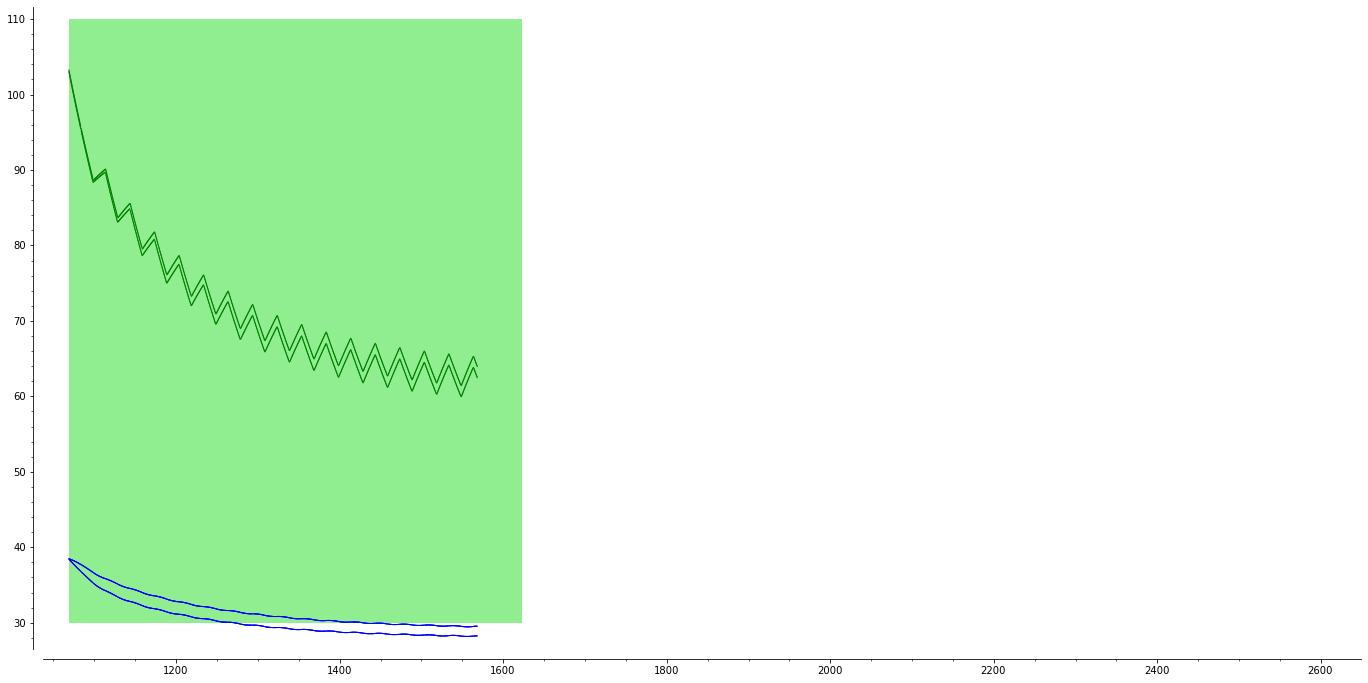

In [33]:
p1 = (verified_sigs2[4].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

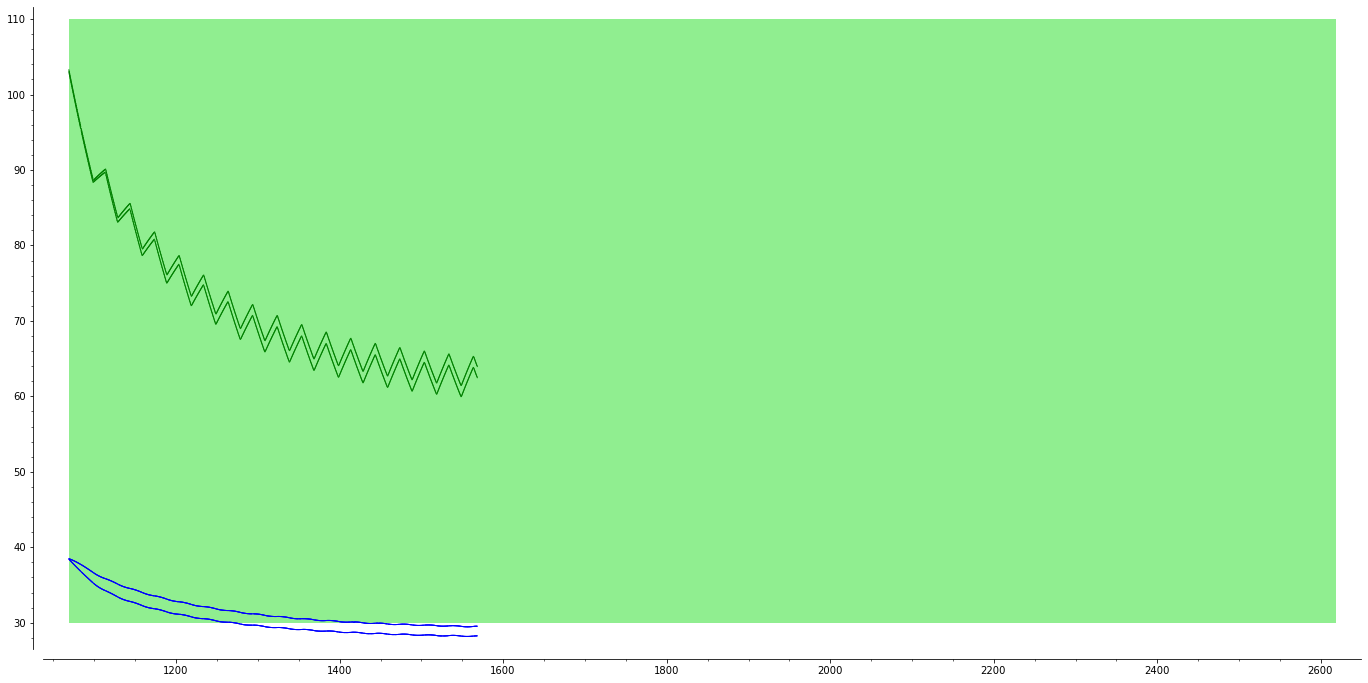

In [34]:
p1 = (verified_sigs2[5].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

#### Anomoly 3

In [35]:
m.self_adaptation_manager.state_machine.anomaly_parameters[2]

(2010.5938409201124,
 2510.5938409201126,
 32.607154528547476,
 59.77326802388883,
 21,
 3.0,
 10,
 0,
 102.?,
 1.?,
 227.76228512,
 1.92343277)

In [36]:
verified_trace3, verified_model3 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[2])
verified_sigs3 = m.self_adaptation_manager.state_machine.verified_monitoring_results[2]

regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[59.773268023888832 .. 59.773268023888833]', '[32.607154528547475 .. 32.607154528547476]', '[101.66355500898725 .. 102.91060090742477]', '[0.91905795830607917 .. 1.9068265129935769]']
ran verified simulation in 19.66717767715454 sec


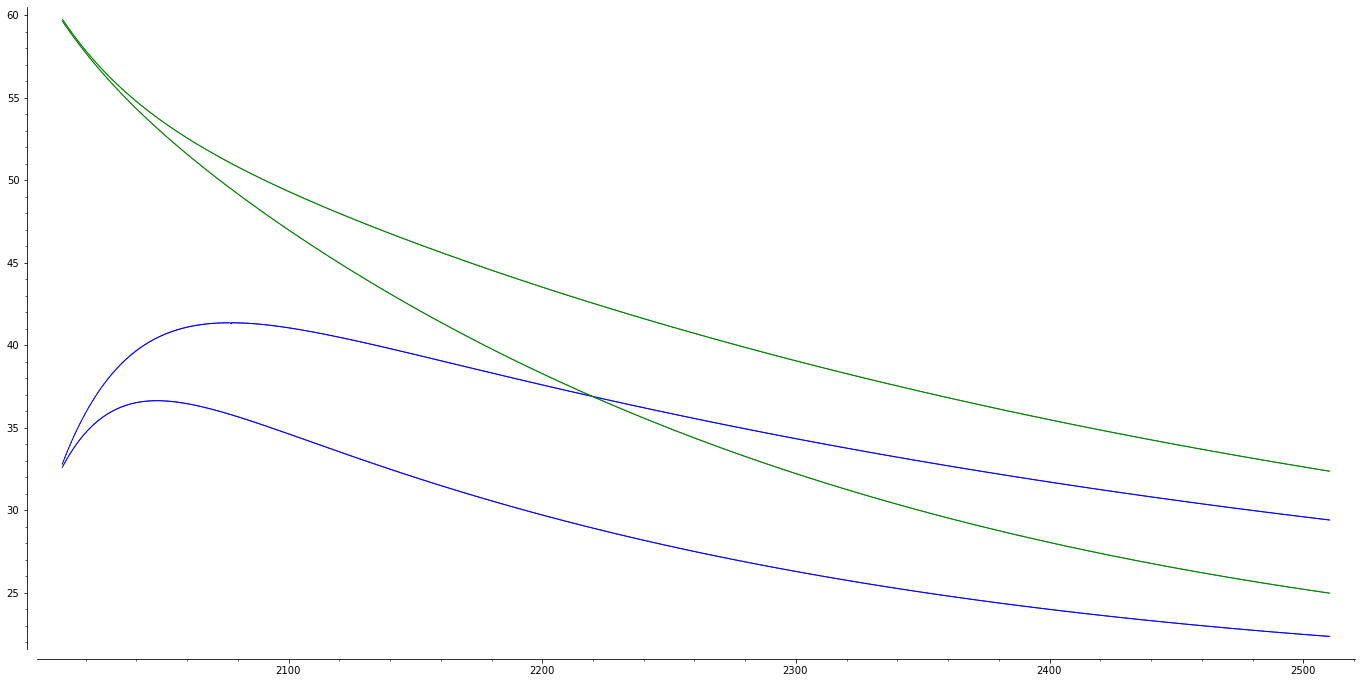

In [37]:
p = verified_trace3.plot(('T_A', 'T_H'), color=('blue', 'green')); p.matplotlib()

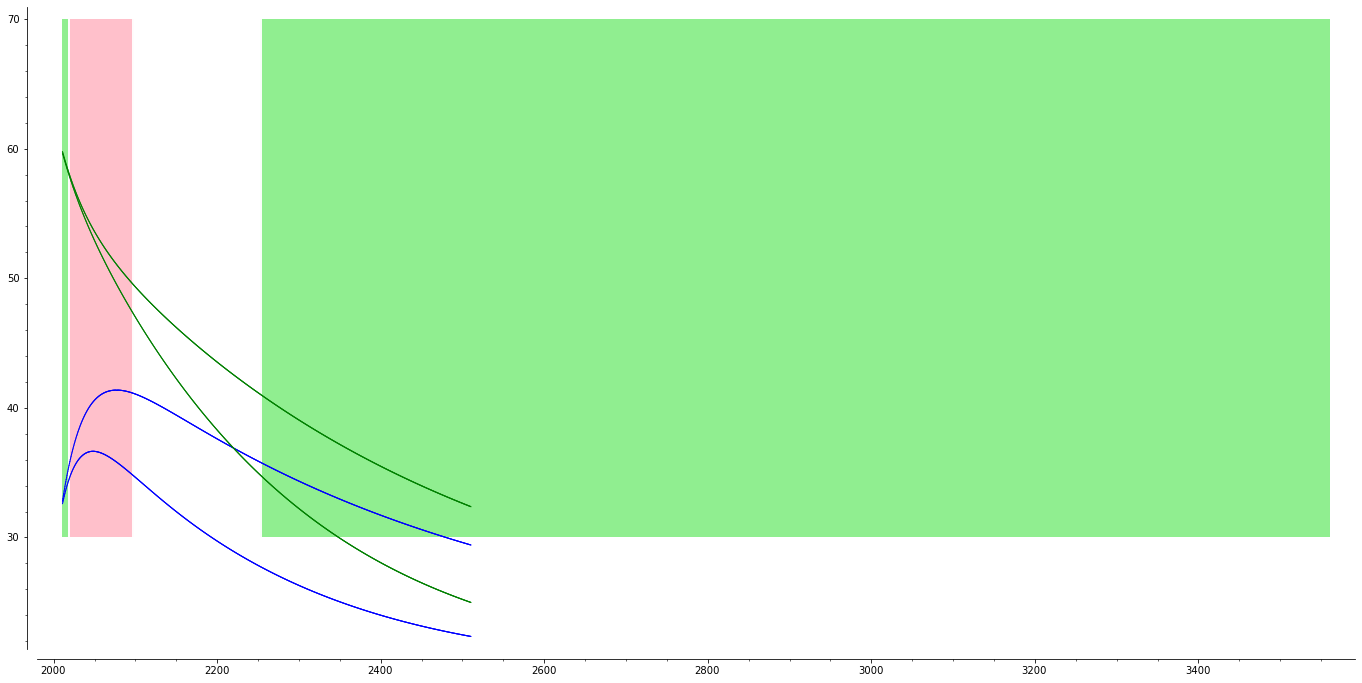

In [38]:
p1 = (verified_sigs3[0].plot(y_range=(30, 70)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

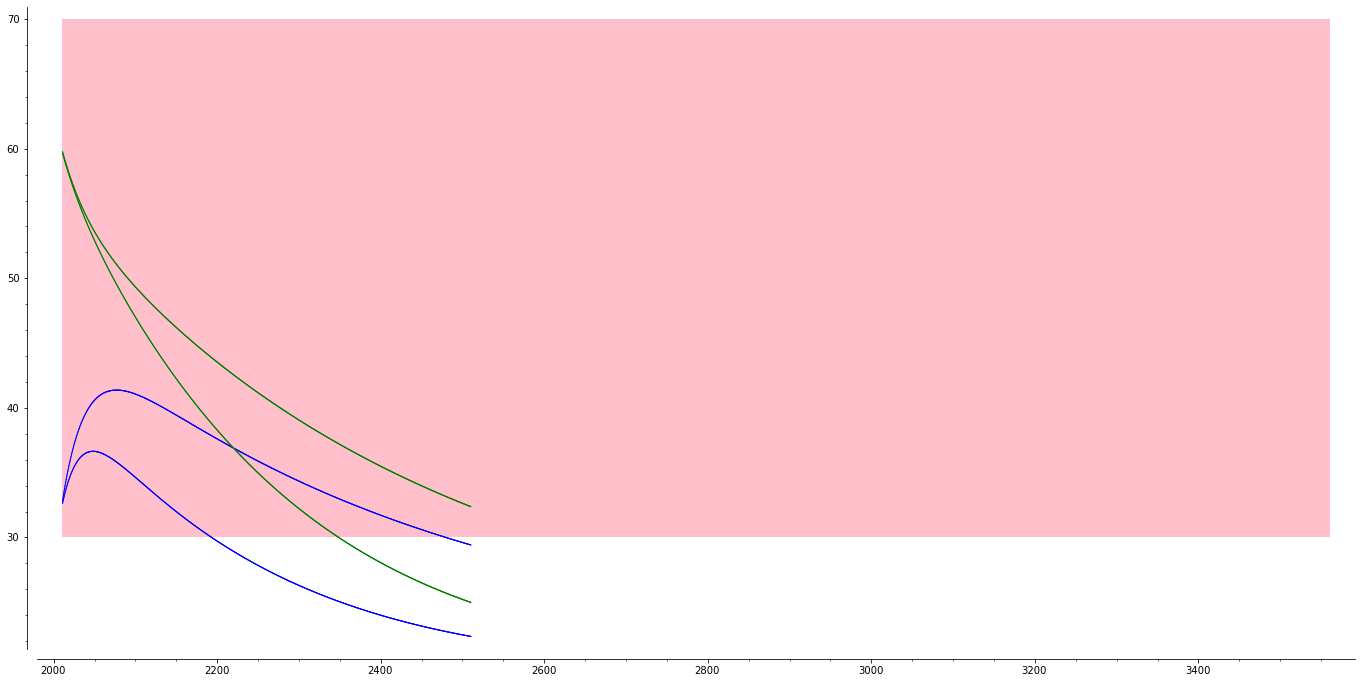

In [39]:
p1 = (verified_sigs3[1].plot(y_range=(30, 70)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

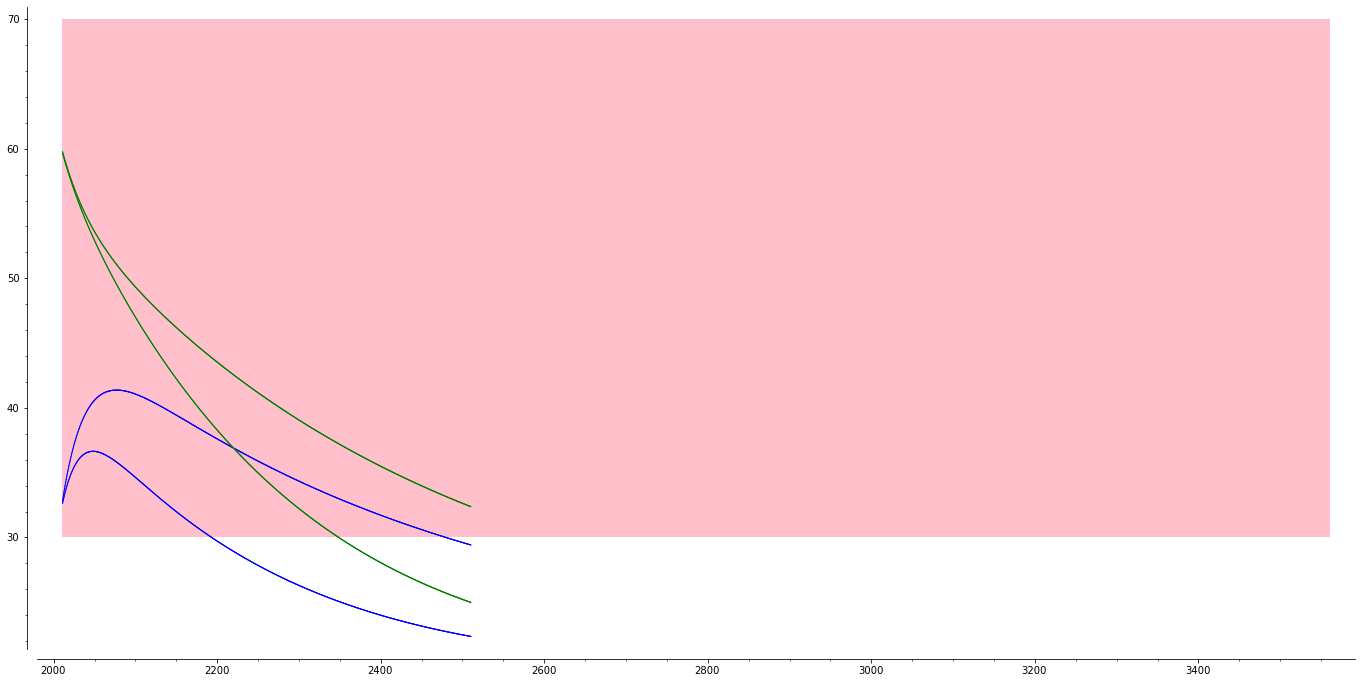

In [40]:
p1 = (verified_sigs3[2].plot(y_range=(30, 70)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

### Experiment outcome

Parameters:
C_air:  [145.69782402, 141.71945977643318, 272.01832249938576, 102.28707795820601]
G_box:  [0.79154106, 7.8338353184845495, 8.315644265351954, 1.412942235649828]
C_heater:  [227.76228512, 227.76228512, 227.76228512, 227.76228512]
G_heater:  [1.92343277, 1.92343277, 1.92343277, 1.92343277]


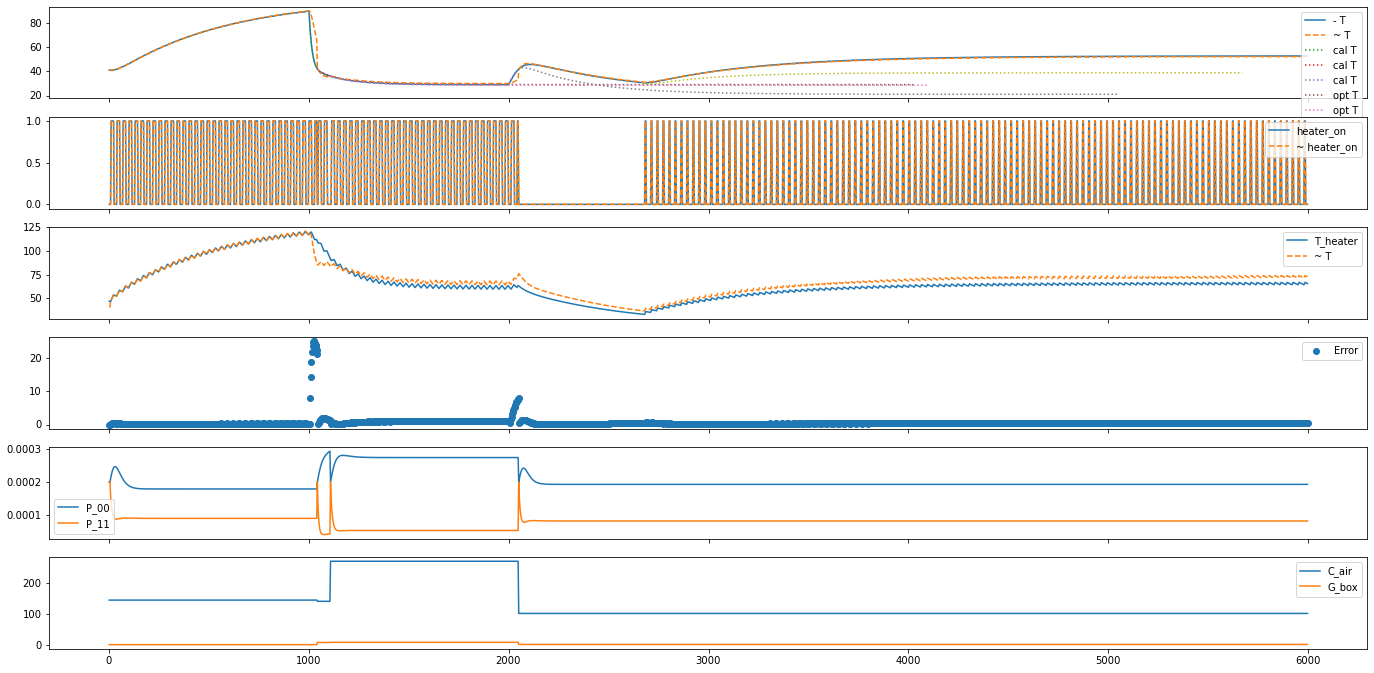

In [41]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex='all')

ax1.plot(m.signals['time'], m.physical_twin.plant.signals['T'], label=f"- T")
ax1.plot(m.signals['time'], m.kalman.signals['out_T'], linestyle="dashed", label=f"~ T")
# ax1.plot(m.signals['time'], m.kalman.signals['out_T_prior'], linestyle="dashed", label=f"~ T_prior")

for (times, trajectory) in database.plant_calibration_trajectory_history:
    ax1.plot(times, trajectory[0, :], label=f"cal T", linestyle='dotted')

for (times, T, T_heater, heater_on) in database.ctrl_optimal_policy_history:
    ax1.plot(times, T, label=f"opt T", linestyle='dotted')

ax1.legend()

ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.physical_twin.ctrl.signals['heater_on']], label=f"heater_on")
ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.kalman.signals['in_heater_on']], linestyle="dashed", label=f"~ heater_on")

ax2.legend()

ax3.plot(m.signals['time'], m.physical_twin.plant.signals['T_heater'], label=f"T_heater")
ax3.plot(m.signals['time'], m.kalman.signals['out_T_heater'], linestyle="dashed", label=f"~ T")

ax3.legend()

# The following plot is incorrect, since it does not match with the actual residual computed by the self_adaptation_manager
# ax4.scatter(m.signals['time'],
#             np.absolute(np.array(m.physical_twin.plant.signals['T']) - np.array(m.kalman.signals['out_T'])),
#             label=f"Error")

ax4.scatter(m.signals['time'],
            m.self_adaptation_manager.signals["temperature_residual_abs"],
            label=f"Error")
ax4.legend()

ax5.plot(m.signals['time'], m.kalman.signals['out_P_00'], label=f"P_00")
ax5.plot(m.signals['time'], m.kalman.signals['out_P_11'], label=f"P_11")

ax5.legend()

ax6.plot(m.signals['time'], m.kalman.signals['C_air'], label=f"C_air")
ax6.plot(m.signals['time'], m.kalman.signals['G_box'], label=f"G_box")

ax6.legend()

print("Parameters:")
print("C_air: ", database.C_air)
print("G_box: ", database.G_box)
print("C_heater: ", database.C_heater)
print("G_heater: ", database.G_heater)
plt.show()